# Prévalence du Listeria dans le lait cru

In [1]:
!ls

README.md                 listeria.txt              projets2021.pdf
exploratoire_claire.ipynb mcmc.ipynb


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as rd

In [32]:
data = pd.read_csv('listeria.txt', sep=',')
data.columns = ['nb_pos', 'nb_test']
new_row = {'nb_pos':0, 'nb_test':600}
data = data.append(new_row, ignore_index=True)

In [46]:
data['prob']=data["nb_pos"]/data['nb_test']
proba_constante = sum(data['nb_pos'])/sum(data['nb_test'])

In [47]:
proba_constante

0.0010564383073439964

# Question 1 : détermination de la loi a posteriori

On suppose dans un premier temps que la probabilité de présence de listeria dans toutes les études est constante. 

Modèle binomial : $r_i \sim \mathcal{B}(n_i,p)$ de fdr $f(r_i, p) = p^r_i (1-p)^{n_i-r_i}$ 

Loi a priori : $p \sim \mathcal{B}eta(\alpha,\beta)$ avec $\alpha, \beta = 1$ ce qui revient à avoir $p \propto \mathcal{U}([0,1])$ 

Loi a posteriori : $\pi(p|r_i) \propto f(r_i,p) \mathbb{1}_{[0,1]}(r_i) \propto p^{(r_i+1)-1} (1-p)^{(n_i-r_i+1) -1} \sim \mathcal{B}eta(r_i+1, n_i-r_i+1)$

On suppose dans un second temps que la probabilité de présence de listeria est variable selon les études.  

Modèle binomial : $r_i \sim \mathcal{B}(n_i,p_i)$ de fdr $f(r_i, p_i) = p_i^{r_i} (1-p_i)^{n_i-r_i}$ 

Loi a priori : $p_i \sim \mathcal{B}eta(\alpha,\beta)$ 

Paramétrisation : $\alpha, \beta$ tels que $\mu = \alpha/(\alpha+\beta) \sim \mathcal{U}([0,1])$ et $\kappa = \alpha + \beta \sim \mathcal{E}(0.1)$

Loi a posteriori : 
$\pi(p_i|r_i) \propto f(r_i,p_i) p_i^{\alpha -1} (1-p_i)^{\beta -1} $

$\pi(p_i|r_i) \propto p_i^{r_i} (1-p_i)^{n_i-r_i} p_i^{\alpha -1} (1-p_i)^{\beta -1} $

$\pi(p_i|r_i) \propto p_i^{r_i+\alpha-1} (1-p_i)^{n_i-r_i+\beta -1 }  $

D'où $\pi(p_i|r_i) \sim \mathcal{B}eta(\alpha+r_i, \beta - n_i +r_i)$

In [ ]:
donnees = []

<AxesSubplot:xlabel='prob', ylabel='Count'>

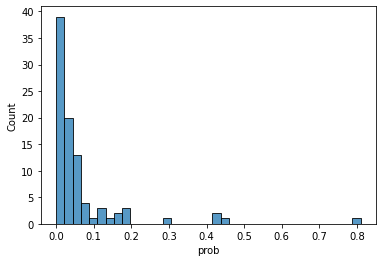

In [42]:
sns.histplot(data, x="prob")

### Loi exponentielle 



In [43]:
def gen_exp(theta):
    u = rd.random()
    return -1/theta*np.log(1-u)

### Loi Beta
Remarque : sommer les cas/les études pour un gros échantillon
Simuler une loi beta(alpha, beta) à l'aide de simulation de lois gammas. 

In [63]:
def gamma(x):
    l = [gen_exp(x) for i in range(10000)]
    return mean(l)
        
def f(x, a, b):
    return b**a*x**(a-1)*exp(-bx)/gamma(a)


In [64]:
def gen_gamma(alpha,beta):
    # si alpha = 1, cela revient à avoir une loi exponentielle de paramètre beta
    if alpha == 1:
        return gen_exp(beta)
    # si alpha est un entier non nul, gamma coïncide avec une somme de alpha va exponentielles
    # de paramètre beta indépendantes
    elif alpha == int(alpha) and alpha > 1 : 
        return sum([gen_exp(beta) for i in range(alpha)])
    # sinon, on va utiliser une méthode de rejet 
    else : 
        while True : 
            # on va utiliser une loi de gamma de paramètres entiers pour g
            x = gen_gamma(int(alpha), beta+1)
            c = beta**alpha/((beta+1)**int(alpha))*gamma(int(alpha))/gamma(alpha)*(alpha-int(alpha))**(alpha-int(alpha))*exp(-int(alpha)+alpha)
            u = rd.random()
            if u <= c*f(x, alpha, beta)/g(x, int(alpha), beta+1):
                return x 
        
        
        
        

<AxesSubplot:ylabel='Count'>

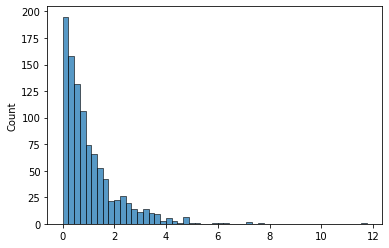

In [70]:
sns.histplot([gen_gamma(1,1) for i in range(1000)])

<AxesSubplot:xlabel='prob', ylabel='Count'>

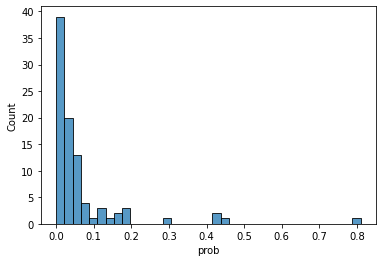

In [68]:
sns.histplot(data['prob'])